Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/CNNAssignment/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/CNNAssignment/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2241
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, validation_split=0.2,subset='training', image_size=(img_height,img_width), batch_size=batch_size)

Found 2241 files belonging to 9 classes.
Using 1793 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed=123, validation_split=0.2,subset='validation', image_size=(img_height,img_width), batch_size=batch_size)

Found 2241 files belonging to 9 classes.
Using 448 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

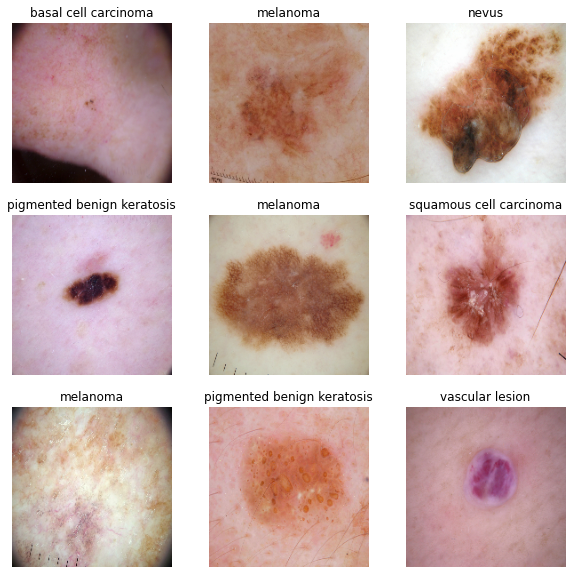

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")




The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
num_classes = 9

model = Sequential([
layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width,3)),
layers.Conv2D(16,3,padding='same',activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32,3,padding='same',activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64,3,padding='same',activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128,activation='relu'),
layers.Dense(9)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
from tensorflow.python.ops.math_ops import truediv
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 111s 951ms/step - loss: 1.9834 - accuracy: 0.2660 - val_loss: 1.7011 - val_accuracy: 0.3571
Epoch 2/20
57/57 [==============================] - 1s 24ms/step - loss: 1.7430 - accuracy: 0.3625 - val_loss: 1.6050 - val_accuracy: 0.4420
Epoch 3/20
57/57 [==============================] - 1s 23ms/step - loss: 1.4579 - accuracy: 0.4802 - val_loss: 1.4634 - val_accuracy: 0.5089
Epoch 4/20
57/57 [==============================] - 1s 23ms/step - loss: 1.3193 - accuracy: 0.5231 - val_loss: 1.4597 - val_accuracy: 0.4911
Epoch 5/20
57/57 [==============================] - 1s 24ms/step - loss: 1.2762 - accuracy: 0.5349 - val_loss: 1.3226 - val_accuracy: 0.5469
Epoch 6/20
57/57 [==============================] - 1s 23ms/step - loss: 1.1320 - accuracy: 0.5962 - val_loss: 1.3051 - val_accuracy: 0.5692
Epoch 7/20
57/57 [==============================] - 1s 23ms/step - loss: 1.0566 - accuracy: 0.6202 - val_loss: 1.4076 - val_accuracy: 0.5335
Epoch 8/20

### Visualizing training results

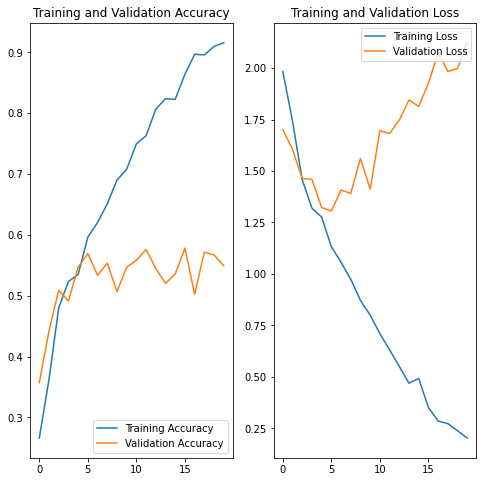

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
Model is overfitting here as Training accuracy is 90% whereas validation accuracy is 55%

### Write your findings here

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal",
                                                  input_shape=(img_height,img_width,3)),
     layers.experimental.preprocessing.RandomRotation(0.2),
     layers.experimental.preprocessing.RandomZoom(0.2),
        
    ]

)

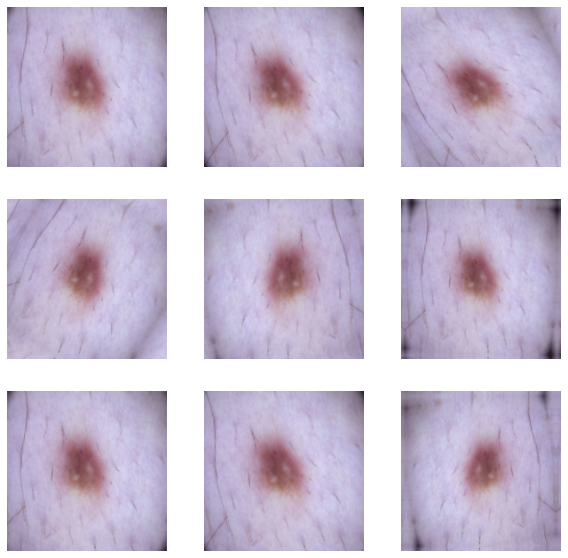

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9

model = Sequential([data_augmentation,
layers.experimental.preprocessing.Rescaling(1.0/255),
layers.Conv2D(16,3,padding='same',activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32,3,padding='same',activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64,3,padding='same',activation='relu'),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Flatten(),
layers.Dense(128,activation='relu'),

layers.Dense(9)
])




### Compiling the model

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 3s 30ms/step - loss: 1.9553 - accuracy: 0.2599 - val_loss: 1.7360 - val_accuracy: 0.3527
Epoch 2/20
57/57 [==============================] - 1s 26ms/step - loss: 1.6777 - accuracy: 0.4077 - val_loss: 1.4900 - val_accuracy: 0.5156
Epoch 3/20
57/57 [==============================] - 2s 27ms/step - loss: 1.5334 - accuracy: 0.4590 - val_loss: 1.5421 - val_accuracy: 0.4576
Epoch 4/20
57/57 [==============================] - 1s 26ms/step - loss: 1.4594 - accuracy: 0.4808 - val_loss: 1.5859 - val_accuracy: 0.4464
Epoch 5/20
57/57 [==============================] - 1s 26ms/step - loss: 1.5174 - accuracy: 0.4635 - val_loss: 1.5200 - val_accuracy: 0.4933
Epoch 6/20
57/57 [==============================] - 1s 26ms/step - loss: 1.4601 - accuracy: 0.4808 - val_loss: 1.3947 - val_accuracy: 0.5246
Epoch 7/20
57/57 [==============================] - 1s 26ms/step - loss: 1.3818 - accuracy: 0.5020 - val_loss: 1.3740 - val_accuracy: 0.5089
Epoch 8/20
57

### Visualizing the results

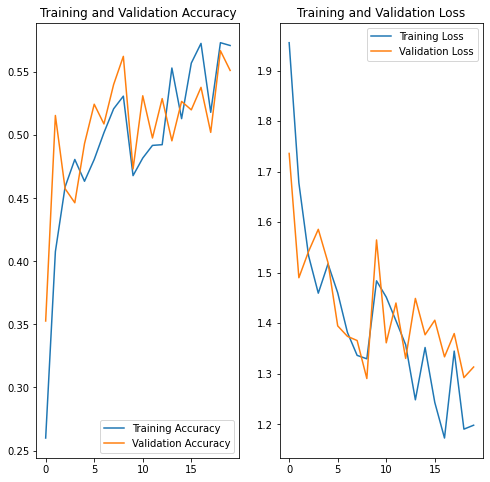

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
Definitely there is an improvement, and model seems to be doing good both on training and validation dataset

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*','*.jpg'))]
len(path_list)

2241

In [27]:
dataframe_dict_original = dict(zip(path_list,lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/CNNAssignment/Train/d...,dermatofibroma
1,/content/gdrive/My Drive/CNNAssignment/Train/d...,dermatofibroma
2,/content/gdrive/My Drive/CNNAssignment/Train/d...,dermatofibroma
3,/content/gdrive/My Drive/CNNAssignment/Train/d...,dermatofibroma
4,/content/gdrive/My Drive/CNNAssignment/Train/d...,dermatofibroma
...,...,...
2236,/content/gdrive/My Drive/CNNAssignment/Train/b...,basal cell carcinoma
2237,/content/gdrive/My Drive/CNNAssignment/Train/b...,basal cell carcinoma
2238,/content/gdrive/My Drive/CNNAssignment/Train/b...,basal cell carcinoma
2239,/content/gdrive/My Drive/CNNAssignment/Train/b...,basal cell carcinoma


class=2,n=95 (4.239%)
class=8,n=139 (6.203%)
class=5,n=462 (20.616%)
class=7,n=181 (8.077%)
class=6,n=77 (3.436%)
class=4,n=359 (16.020%)
class=3,n=438 (19.545%)
class=0,n=114 (5.087%)
class=1,n=376 (16.778%)


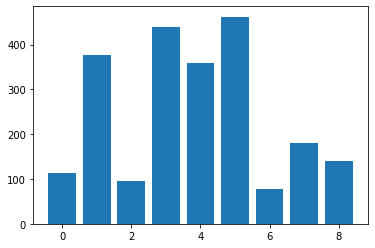

In [29]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
X,y = original_df['Path'],original_df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
  per = v / len(y) * 100
  print('class=%d,n=%d (%.3f%%)' %(k,v,per))
plt.bar(counter.keys(),counter.values())
plt.show()  

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? Class 6
#### - Which classes dominate the data in terms proportionate number of samples? Class 5


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset="/content/gdrive/My Drive/CNNAssignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNNAssignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DDB10EF90>: 100%|██████████| 500/500 [00:18<00:00, 26.80 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNNAssignment/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DDB83E450>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNNAssignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DDB8BA5D0>: 100%|██████████| 500/500 [00:23<00:00, 21.72 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNNAssignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x542 at 0x7F0DDB12F2D0>: 100%|██████████| 500/500 [01:29<00:00,  5.59 Samples/s]


Initialised with 359 image(s) found.
Output directory set to /content/gdrive/My Drive/CNNAssignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F0D9E2C5550>: 100%|██████████| 500/500 [01:30<00:00,  5.51 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNNAssignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DDB19AE50>: 100%|██████████| 500/500 [00:19<00:00, 26.18 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNNAssignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0D9E29AE10>: 100%|██████████| 500/500 [00:44<00:00, 11.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNNAssignment/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DDB8B0C90>: 100%|██████████| 500/500 [00:20<00:00, 24.38 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNNAssignment/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0DDA043150>: 100%|██████████| 500/500 [00:19<00:00, 26.16 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030555.jpg_20c16e96-c29e-44b7-a845-25fa8d5dcf1a.jpg',
 '/content/gdrive/My Drive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025980.jpg_a7fb72d6-00cc-47aa-b583-20589a47120b.jpg',
 '/content/gdrive/My Drive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029248.jpg_29d7b80d-73d4-4106-a41d-164e995d4359.jpg',
 '/content/gdrive/My Drive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025504.jpg_40acf95b-6998-4e7b-8f0c-c22cc4924f82.jpg',
 '/content/gdrive/My Drive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028735.jpg_cb8d64f8-015b-475c-b5cd-b2f80cc2d490.jpg',
 '/content/gdrive/My Drive/CNNAssignment/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_b5998f4d-229e-406e-a481-631276d9b2fe.jpg',
 '/content/gdrive/My Drive/CNNAssignment/Train/dermatofibroma/output/dermatofibrom

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [44]:
path_list_new = "/content/gdrive/My Drive/CNNAssignment/path_list_new"
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [43]:
new_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         359
squamous cell carcinoma       181
vascular lesion               139
dermatofibroma                121
actinic keratosis             114
seborrheic keratosis           77
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [45]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6741 files belonging to 9 classes.
Using 5393 files for training.


#### **Todo:** Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6741 files belonging to 9 classes.
Using 1348 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [49]:
model = Sequential([
layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width,3)),
layers.Conv2D(16,3,padding='same',activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32,3,padding='same',activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64,3,padding='same',activation='relu'),
layers.MaxPooling2D(),
layers.Dropout(0.2),
layers.Flatten(),
layers.Dense(128,activation='relu'),
layers.Dense(9)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [52]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 33s 185ms/step - loss: 1.8348 - accuracy: 0.3035 - val_loss: 1.5462 - val_accuracy: 0.4088
Epoch 2/20
169/169 [==============================] - 31s 181ms/step - loss: 1.4833 - accuracy: 0.4461 - val_loss: 1.4660 - val_accuracy: 0.4562
Epoch 3/20
169/169 [==============================] - 30s 173ms/step - loss: 1.2537 - accuracy: 0.5286 - val_loss: 1.2293 - val_accuracy: 0.5623
Epoch 4/20
169/169 [==============================] - 30s 175ms/step - loss: 1.0948 - accuracy: 0.5911 - val_loss: 1.2012 - val_accuracy: 0.5734
Epoch 5/20
169/169 [==============================] - 31s 176ms/step - loss: 0.9124 - accuracy: 0.6616 - val_loss: 1.0527 - val_accuracy: 0.6224
Epoch 6/20
169/169 [==============================] - 31s 180ms/step - loss: 0.7410 - accuracy: 0.7304 - val_loss: 0.9827 - val_accuracy: 0.6625
Epoch 7/20
169/169 [==============================] - 31s 180ms/step - loss: 0.6591 - accuracy: 0.7599 - val_loss: 0.9590 - val_ac

#### **Todo:**  Visualize the model results

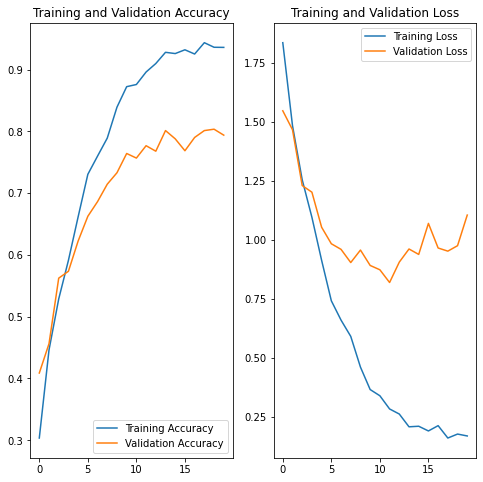

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Bit overfitting, but class reblance has definitely helped
